<a href="https://colab.research.google.com/github/vksriharsha/Human-Cancer-Prediction/blob/main/HumanCancer_prediction_Prostate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycm

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from pycm import *
from matplotlib.pyplot import figure
import seaborn as sn

In [ ]:
tcga_data_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_Data_18212_7142.tsv', delimiter='\t')

tcga_metadata_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_MetaData_7142_23.tsv', delimiter='\t')

tcga_data_df = tcga_data_df.drop(['NCBI_description','NCBI_other_designations','NCBI_chromosome', 'NCBI_map_location', 'NCBI_OMIM', 'CGC_Tumour Types(Somatic)', 'CGC_Tumour Types(Germline)', 'CGC_Role in Cancer', 'CGC_Translocation Partner', 'CGC_Somatic', 'CGC_Germline', 'CGC_Mutation Types', 'CGC_Molecular Genetics', 'CGC_Tissue Type', 'CGC_Cancer Syndrome', 'CGC_Other Syndrome', 'OMIM_Comments', 'OMIM_Phenotypes', 'Hugo_RefSeq IDs', 'Hugo_Ensembl gene ID', 'Hugo_Enzyme IDs', 'Hugo_Pubmed IDs', 'Hugo_Locus group', 'Hugo_Gene group name'],axis=1)

tcga_data_df = tcga_data_df.T

tcga_data_df.columns = tcga_data_df.iloc[0]

tcga_data_df = tcga_data_df.drop(tcga_data_df.index[0])

def x(a):
    return np.log2(a.astype('float32') + 1)

tcga_data_df  = tcga_data_df.apply(x, axis = 1)

tcga_data_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Hugo_Symbol,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,MMP21,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,1.201634,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,1.669027,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,0.475085,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,1.778209,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330

In [ ]:
tcga_metadata_df = tcga_metadata_df[['portions.analytes.aliquots.submitter_id', 'clinical.disease']]
tcga_metadata_df['clinical.disease'] = tcga_metadata_df['clinical.disease'].fillna('normal')
tcga_metadata_df = tcga_metadata_df.set_index('portions.analytes.aliquots.submitter_id')

tcga_metadata_df

,clinical.disease
portions.analytes.aliquots.submitter_id,
TCGA-3C-AAAU-01A-11R-A41B-07,BRCA
TCGA-3C-AALI-01A-11R-A41B-07,BRCA
TCGA-3C-AALJ-01A-31R-A41B-07,BRCA
TCGA-3C-AALK-01A-11R-A41B-07,BRCA
TCGA-4H-AAAK-01A-12R-A41B-07,BRCA
...,...
GTEX-ZZPU-0526-SM-5E44U,Lung_normal
GTEX-ZZPU-0626-SM-5E43T,Breast_normal
GTEX-ZZPU-1326-SM-5GZWS,Thyroid_normal


In [ ]:
tcga_data_df = pd.merge(tcga_data_df, tcga_metadata_df, left_index=True, right_index=True)

tcga_data_df

,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996,BRCA
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009,BRCA
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993,BRCA
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016,BRCA
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330021,7.919995,...

In [ ]:
some_values = ['PRAD', "Prostate_normal"]
tcga_data_lung_df = tcga_data_df.loc[tcga_data_df['clinical.disease'].isin(some_values)]

In [ ]:
le = preprocessing.LabelEncoder()
# tcga_data_df['tissue'] = le.fit_transform(tcga_data_df.tissue.values)
tcga_data_lung_df['clinical.disease'] = le.fit_transform(tcga_data_lung_df['clinical.disease'].values)

tcga_data_lung_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-VN-A88P-01A-11R-A352-07,10.750004,8.339984,8.420002,4.359662,9.639992,9.389997,0.475085,9.309999,3.140779,7.840023,0.669027,7.049957,3.229588,9.180009,7.579995,8.680008,1.207893,5.360013,8.809993,0.000000,9.229997,11.269998,2.469886,12.950000,4.650190,11.689998,4.349790,9.189998,10.469997,4.319762,4.959770,9.340006,10.580004,7.260026,1.910733,4.090006,7.560027,12.730000,9.689998,9.709997,...,10.559999,10.339994,8.650010,13.310000,1.709291,9.380007,13.910000,7.130004,10.260002,8.239981,10.260002,6.439956,7.649975,1.438293,9.729995,0.871844,1.778209,7.989990,10.139998,11.789998,0.000000,6.749937,6.549977,10.189998,9.750004,10.339994,6.090006,10.360003,1.220330,12.600001,6.099926,7.840023,3.229588,9.509993,5.770036,8.119979,6.960002,7.360013,9.449994,0
TCGA-CH-5739-01A-11R-1580-07,10.670001,8.609991,8.369989,6.269968,10.630003,9.720005,2.440952,9.410006,5.750071,9.140012,3.680324,7.190022,1.839960,8.919995,8.399982,9.000000,1.448901,4.750071,8.750004,0.000000,9.249990,11.070001,3.129283,11.660001,5.990047,10.679999,4.339850,9.760005,9.609991,4.709842,4.399855,9.539992,10.969998,7.859970,1.189034,5.479942,8.559989,12.720000,7.689998,10.549996,...,10.960002,9.919995,8.979997,12.309999,1.899176,8.500006,11.429997,7.349967,8.910013,8.830009,10.210002,6.149951,7.950002,0.000000,9.449994,3.260026,1.150560,8.559989,8.669984,10.969998,2.339137,7.269968,7.000000,5.150153,9.539992,10.909998,7.570007,10.580004,1.589764,12.320000,7.130004,8.389997,4.950002,5.270155,4.629940,8.880013,8.030005,5.980025,8.379985,0
TCGA-V1-A9OH-01A-11R-A41O-07,10.830000,7.969991,9.549996,4.349790,10.040002,8.780015,2.211012,8.950002,5.620000,8.019979,0.687061,7.409985,0.000000,8.919995,8.019979,8.500006,0.632268,3.900142,8.669984,1.521051,6.970048,9.590007,2.819668,12.480000,9.120005,11.230002,4.539779,9.170000,9.570007,3.859970,3.640390,9.760005,10.889998,8.290019,0.000000,8.290019,7.919995,13.179999,8.319988,9.680008,...,10.370001,10.529997,9.050012,12.950000,3.279471,9.140012,11.779999,7.309977,9.820004,8.109987,10.299997,5.939932,6.010108,0.000000,9.799994,1.691534,1.550901,7.869995,8.190022,11.590002,0.632268,5.980025,7.069960,6.060048,9.670001,10.450005,7.589988,10.370001,1.269033,12.700000,5.819923,8.630013,3.200065,4.719731,4.679761,8.579994,7.449974,7.570007,9.069986,0
TCGA-EJ-7331-01A-11R-2118-07,11.410001,8.770003,8.450015,6.380072,10.989998,9.659996,2.570463,9.520010,5.090006,9.030005,0.000000,8.050012,0.948601,8.770003,8.230021,8.250014,2.010780,4.880196,8.609991,0.000000,11.009996,11.040002,2.169925,11.579999,8.150001,10.459995,4.019702,10.420002,9.919995,5.889960,4.310340,9.490008,11.070001,8.960002,1.207893,5.889960,8.750004,12.780001,8.710014,10.270003,...,11.009996,10.379995,8.869995,12.640001,2.381283,8.950002,13.930000,7.290019,8.540011,9.320011,9.919995,5.569856,8.939991,1.238787,9.509993,0.622930,1.182692,8.470008,9.849999,11.159997,1.269033,6.739983,7.579995,6.090006,9.820004,10.979997,6.869995,10.200004,1.028569,12.579999,6.410070,8.750004,5.389911,5.350143,5.189825,8.470008,7.409985,7.760021,7.939991,0
TCGA-XK-AAIV-01A-11R-A41O-07,10.759996,8.939991,8.360013,5.520108,9.979997,9.289996,4.519794,9.429993,7.090006,9.249990,1.269033,8.050012,0.000000,8.960002,8.550015,7.419960,0.918386,5.640100,8.729995,3.260026,10.009996,8.680008,3.060047,12.170000,7.260026,11.060000,6.400025,9.689998,9.670001,6.219943,6.889960,10.889998,11.299997,7.049957,0.000000,2.550901,7.910013,12.060000,8.339984,8.759988,...,9.809993,

In [ ]:
classlist = list(le.classes_)

classdict = {v: k for v, k in enumerate(classlist)}

classdict

{0: 'PRAD', 1: 'Prostate_normal'}

In [ ]:
X = tcga_data_lung_df.iloc[:,:18212].values
Y = tcga_data_lung_df.iloc[:,18212:18213].values

genes = list(tcga_data_lung_df.columns)

X = np.asarray(X).astype('float32')
X

array([[10.750004 ,  8.339984 ,  8.420002 , ...,  6.960002 ,  7.360013 ,
         9.449994 ],
       [10.670001 ,  8.609991 ,  8.369989 , ...,  8.0300045,  5.9800253,
         8.379985 ],
       [10.83     ,  7.9699907,  9.549996 , ...,  7.449974 ,  7.5700073,
         9.069986 ],
       ...,
       [11.199997 ,  8.579994 ,  9.24999  , ...,  7.890021 ,  7.2600255,
         8.510013 ],
       [10.510002 ,  9.480002 ,  9.779999 , ...,  7.649975 ,  6.5299773,
         7.880012 ],
       [11.070001 ,  8.729995 ,  8.659996 , ...,  7.9500017,  8.279982 ,
         8.559989 ]], dtype=float32)

In [ ]:
X.shape

(532, 18212)

In [ ]:
genes.pop()
len(genes)

18212

In [ ]:
v_threshold = VarianceThreshold(threshold=5)
v_threshold.fit(X)

result = v_threshold.get_support()

bin = np.bincount(result)

indices = []

for idx, i in enumerate(result):
  if i == False:
    indices.append(idx)
  
X = np.delete(X, indices, 1)



In [ ]:
X.shape

(532, 214)

In [ ]:
Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [ ]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)


delete_multiple_element(genes, indices)
print(len(genes))

214


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,stratify=Y,test_size = 0.25, random_state=42)

X_train

array([[ 0.1505597 ,  4.739848  ,  3.3305585 , ...,  4.2203298 ,
         0.        ,  9.990005  ],
       [ 1.8718437 ,  0.        ,  2.5897634 , ...,  3.7697718 ,
         1.2570106 ,  8.98999   ],
       [ 3.0891593 ,  4.1001368 ,  2.729009  , ...,  3.1407785 ,
         5.469886  , 14.67      ],
       ...,
       [ 0.        ,  6.590063  ,  0.        , ...,  2.9800253 ,
         0.        , 10.080005  ],
       [ 2.6803243 ,  1.5993178 ,  0.        , ...,  0.        ,
         1.5410191 , 11.689998  ],
       [ 0.12432818,  0.8718436 ,  4.5999126 , ...,  5.3998547 ,
         0.47508487,  6.179909  ]], dtype=float32)

In [ ]:
clf = RandomForestClassifier(n_estimators = 100)  
  
clf.fit(X_train, y_train)
  
y_pred = clf.predict(X_test)
  
from sklearn import metrics  
print()

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until



ACCURACY OF THE MODEL:  1.0


In [ ]:
cm = ConfusionMatrix(y_test, y_pred,digit=5)
# cm.relabel(mapping=classdict)
print(cm)

Predict   0         1         [0]       [1]       
Actual
0         0         0         0         0         

1         0         0         0         0         

[0]       107       0         0         0         

[1]       0         26        0         0         





Overall Statistics : 

95% CI                                                            (0.0,0.0)
ACC Macro                                                         0.5
ARI                                                               1.0
AUNP                                                              None
AUNU                                                              None
Bangdiwala B                                                      None
Bennett S                                                         -0.33333
CBA                                                               0.0
CSI                                                               None
Chi-Squared                                                   

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index = genes).sort_values(ascending = False)
feature_imp[0:10]

RP11-73M18.2    0.092467
PIK3R2          0.062794
AC006538.4      0.059692
DLX1            0.056431
LY6G6D          0.054704
HOXC4           0.046157
SFT2D3          0.044205
PIGY            0.037627
SEMG1           0.027189
TP63            0.024437
dtype: float64

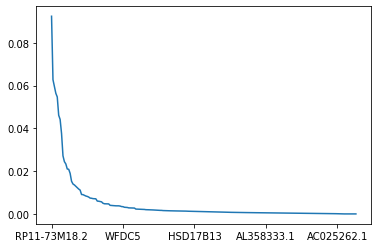

In [ ]:
feature_imp.plot()

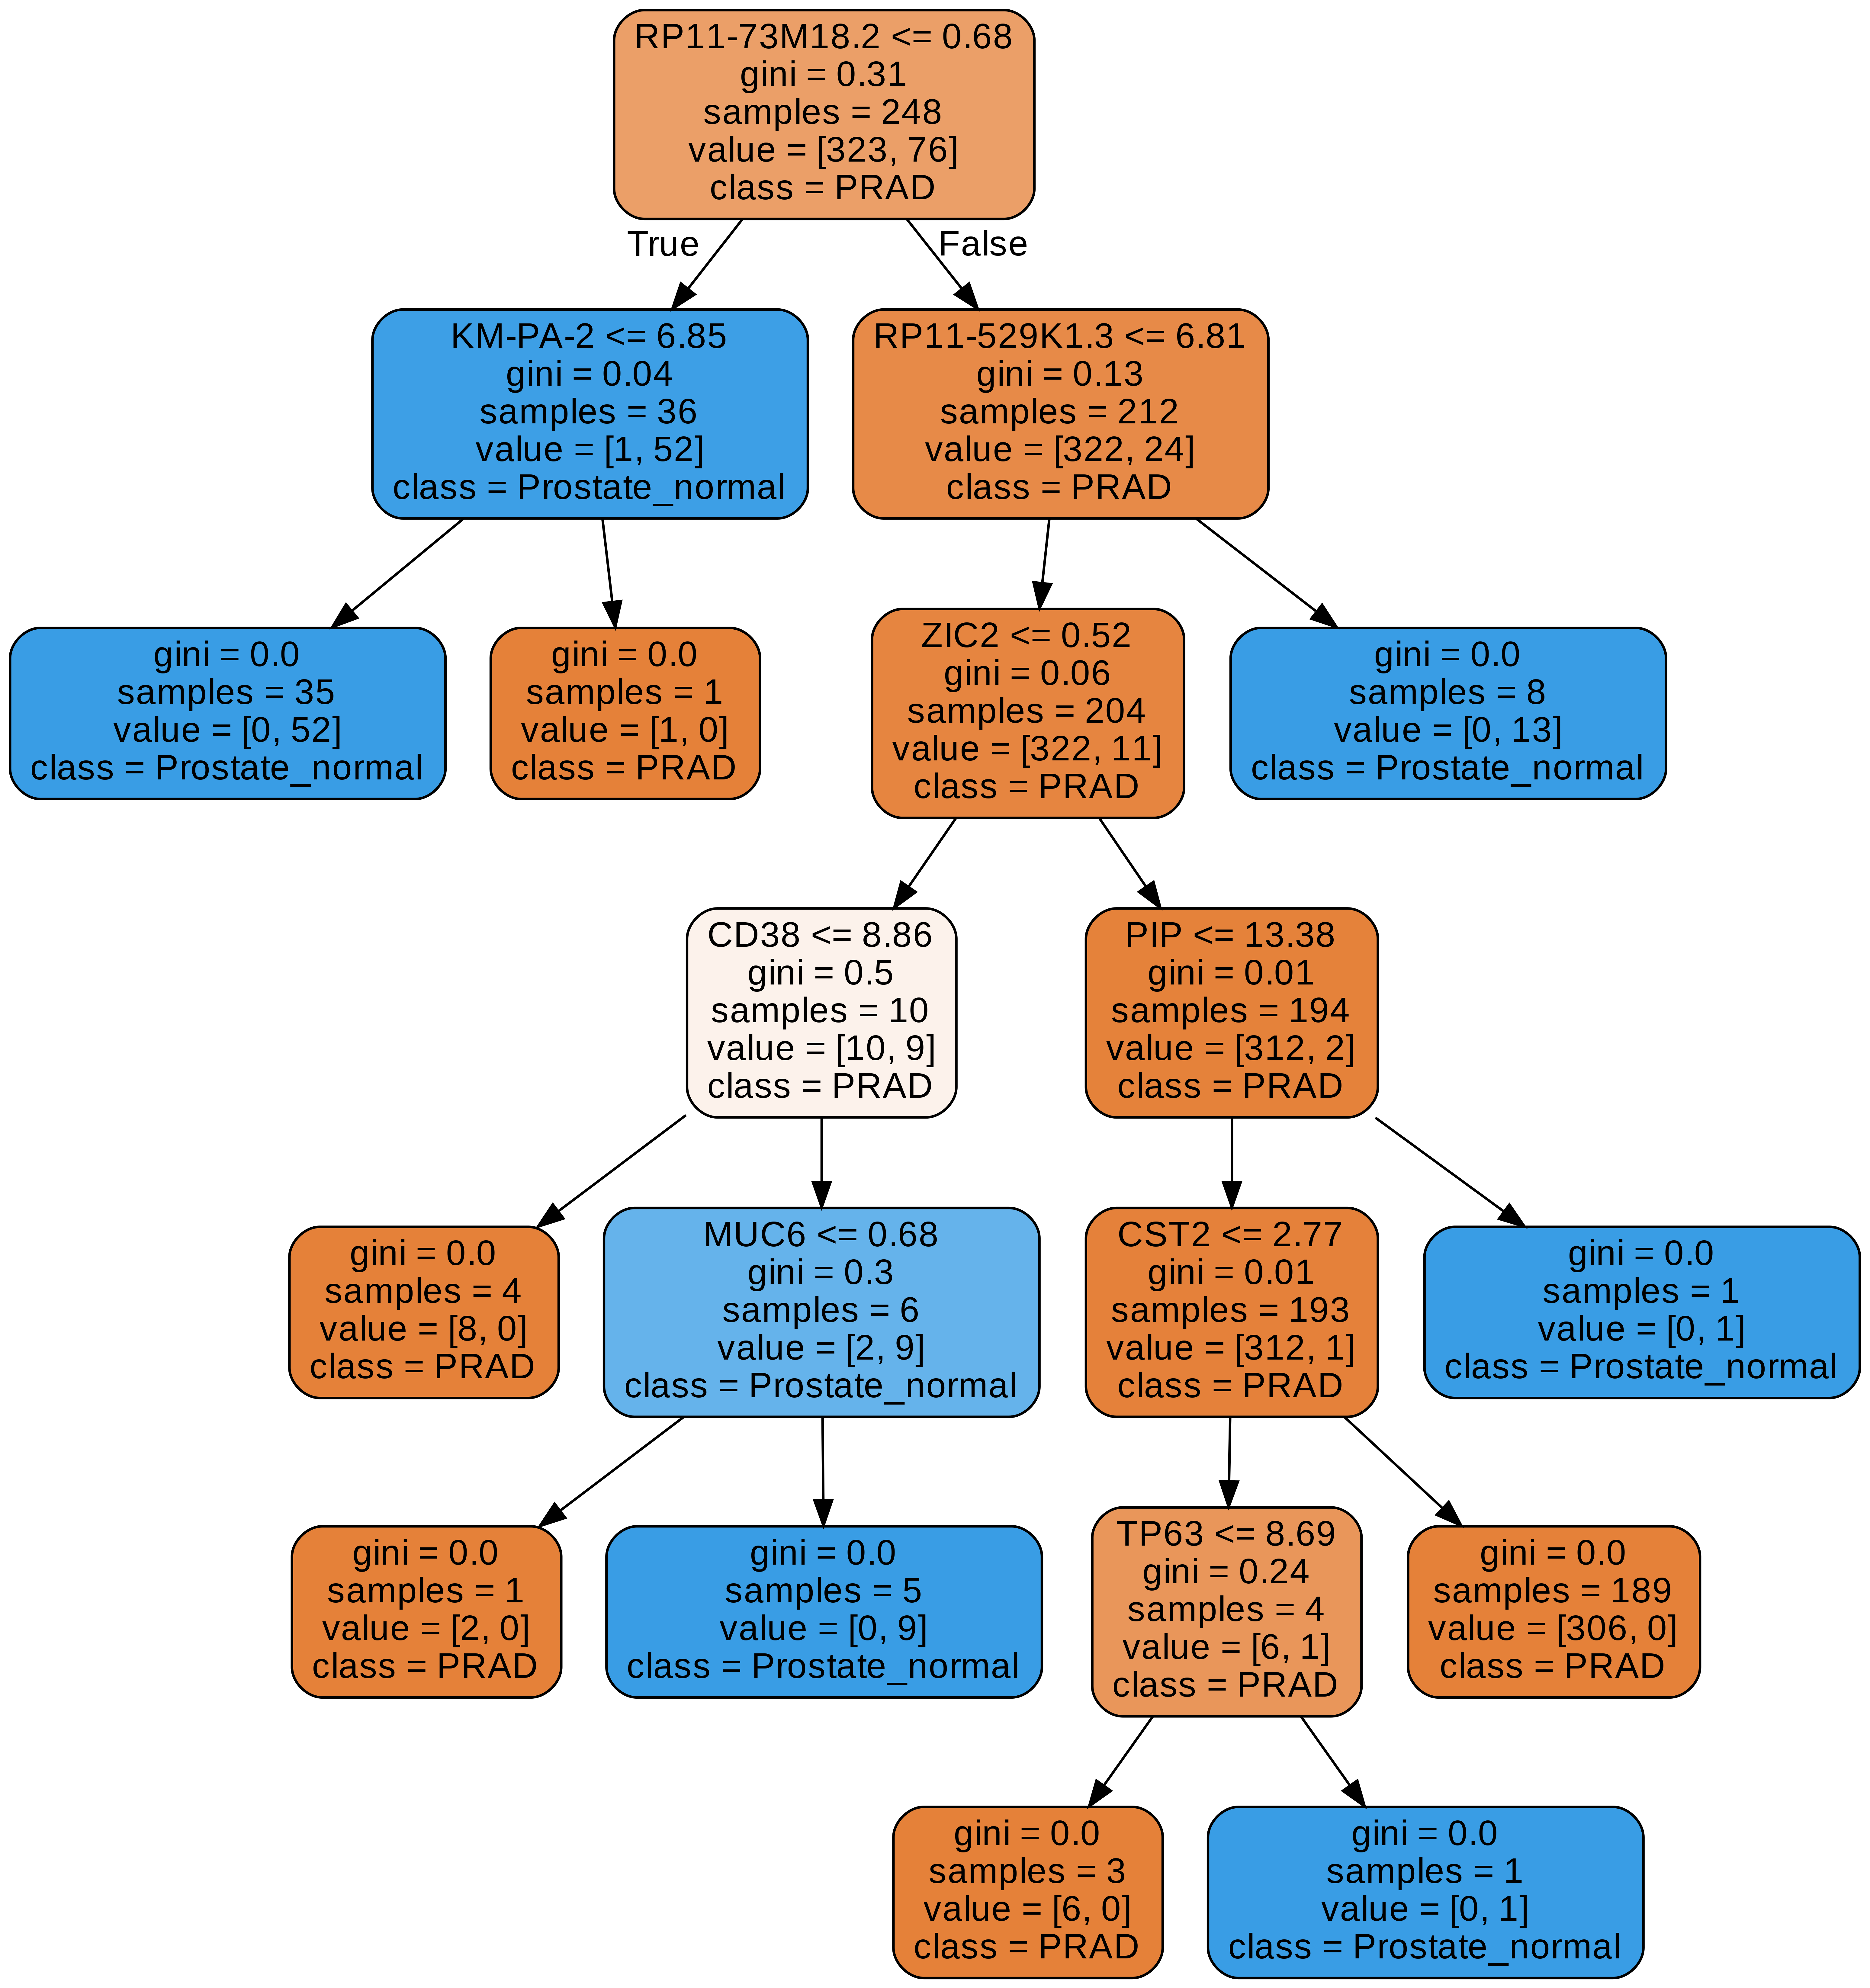

In [ ]:
from sklearn.tree import export_graphviz

estimator = clf.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = genes,
                class_names = classlist,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')